In [60]:
import warnings

import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

Сгенерируем датасет Игрушка Дьявола

In [2]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 1000
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

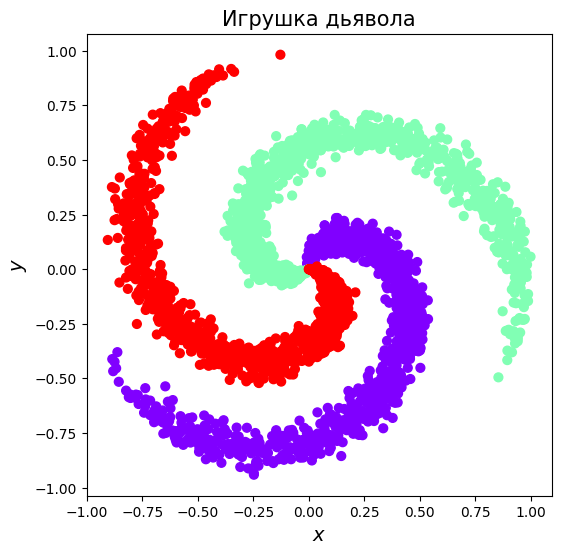

In [3]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(6, 6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [4]:
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.9, random_state=42)
print(X_train.shape, y_train.shape)

torch.Size([2700, 2]) torch.Size([2700])


Сейчас мы хотим научиться самостоятельно создавать наследников nn.Module. До этого мы делали нейросети с помощью класса nn.Sequential, попробуем построить такую же сеть, как на прошлом семинаре, но самостоятельно.

### Sequential

In [63]:
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв;
# D_out - размерность выходного слоя (суть - количество классов)
D_in, H, D_out = 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

Что такое модуль и как он устроен? Во-первых, модуль это такой строительный блок для нейронок, с помощью модуля можно задать любую дифференциируемую по своему параметру функцию. Применяются модули так же, как и обычные функции с синтаксисом
> module_instance(var1, var2)

При этом внутри вызывается функция forward с теми же аргументами, а ее выход возвращается как результат вызова модуля. Зачем же нужно так странно оборачивать обычные функции в модули?

* Это позволяет очень удобно следить за параметрами, которые надо изменять. Когда мы хоти получить все параметры можно просто рекурсивно пройтись по всем полям модели, посмотреть, какие из ни параметры сами по себе, а какие являются модулями и содрежат параметры внутри, а потом все это собрать.

_По этой причине если вы используете внутри своего модуля какие-то еще модули их надо класть просто в поле класса, если это единичный модуль, и в класс **nn.ModuleList** или **nn.ModuleDict**, если у вас список или словарь используемых модулей. Если же в модели у вас есть како-то собственный вес, то недостаточно положить тензор в поле класса, его надо обернуть в **nn.Parameter, nn.ParameterList** или **nn.ParameterDict** в зависимотси от того, что именно у вас._

* Такая организация позволяет достаточно безболезненно расширять PyTorch и писать для него свои функции, которые нельзя выразить композицией уже существующих. Пригождается это редко, поэтому сегодня мы не будем писать свое расширение.

* Код, разделенный на модули, это просто красиво.

### Module

In [64]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.f_lin = nn.Linear(D_in, H)
        self.s_lin = nn.Linear(H, D_out)

    def forward(self, X):
        X = F.relu(self.f_lin(X))
        return F.softmax(self.s_lin(X))

model = MyModule()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), 1e-1)

In [65]:
from torchsummary import summary

In [66]:
summary(model,  (D_in,), batch_size=2700)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [2700, 100]             300
            Linear-2                  [2700, 3]             303
Total params: 603
Trainable params: 603
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.12
Params size (MB): 0.00
Estimated Total Size (MB): 2.14
----------------------------------------------------------------


In [67]:
# получаем веса
model.f_lin.weight[:3]

tensor([[ 0.1336, -0.2535],
        [-0.4262, -0.4538],
        [ 0.6092,  0.6598]], grad_fn=<SliceBackward0>)

In [68]:
# получаем смещения
model.f_lin.bias[:3]

tensor([0.3283, 0.5969, 0.2026], grad_fn=<SliceBackward0>)

### Another Module implementation

In [ ]:
'''
# Создается класс MyModule, наследующийся от torch.nn.Module.
# В конструкторе __init__ определяются атрибуты модели:
# fc1 - полносвязный слой (Linear) с одним входом и заданным числом скрытых нейронов (n_hidden_neurons).
# act1 - функция активации (Sigmoid).
# fc2 - полносвязный слой (Linear) с заданным числом скрытых нейронов (n_hidden_neurons) и одним выходом.

class MyModule(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)


    # Метод forward определяет прямой проход (forward pass) модели:
    # Входной тензор x проходит через полносвязный слой fc1.
    # Результат проходит через функцию активации act1.
    # Полученный выход проходит через полносвязный слой fc2.
    # Результат возвращается.

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

def predict(net, x, y):
    y_pred = net.forward(x)
predict(model, x, y)

def loss(pred, target):
    squares = (pred - target) ** 2
    return squares.mean()

model = MyModule(x)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch_index in range(2000):
    optimizer.zero_grad()

    y_pred = model.forward(x_train)
    loss_val = loss(y_pred, y_train)

    loss_val.backward()
    optimizer.step()
'''

Пример нейронки для регрессии: <a href="https://github.com/SlinkoIgor/Neural_Networks_and_CV/blob/master/module03_sin_prediction.ipynb">Stepic</a>

Поговорим немного подробнее о `softmax` и `CrossEntropyLoss`.

Напоминание: softmax-функция выглядит следующим образом
$$Softmax(x) = \begin{pmatrix}
\dfrac{e^{x_1}}{\sum\limits_{i=0}^{m} e^{x_i}},\; \dots,\; \dfrac{e^{x_m}}{\sum\limits_{i=0}^{m} e^{x_i}}
\end{pmatrix} $$

Таким образом, после применения softmax-функции мы получили вектор чисел из интервала $(0, 1)$, которые мы будем интерпретировать как вероятности классов.

Аналогично тому, как мы обощили сигмоиду на многоклассовый случай и получили softmax, можно обобщить и функцию потерь, получив _кросс-энтропию_:

$$CrossEntropy(x) = -\sum\limits_{i=0}^m y_i \cdot log(Softmax(x)_i), $$

где $y_i$ – истинная метка класса ($1$ если $x$ принадлежит $i$-ому классу и $0$ иначе)

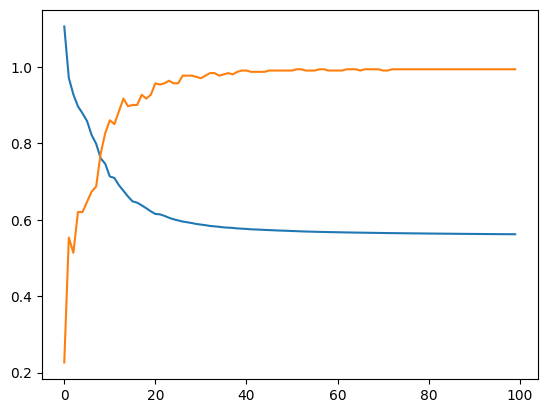

In [71]:
losses = []
accs = []

for t in range(100):
    # forward
    y_pred = model(X_train)

    # loss
    loss = loss_fn(y_pred, y_train)
    losses.append(loss.item())

    # accuracy
    _, y_pred_val = model(X_val).max(dim=1)
    num_correct = (y_pred_val == y_val).sum()
    num_samples = y_pred_val.size(0)
    acc = num_correct / num_samples
    accs.append(acc.item())

    # backward
    optim.zero_grad()
    loss.backward()
    optim.step()

plt.plot(losses)
plt.plot(accs)
plt.show()

In [72]:
# Предскажем вероятности принадлежности к каждому классу на валидационной выборке
'''
Вызов model(X_val) вернет тензор вероятности принадлежности к каждому классу:
[[2.4380e-05, 9.9998e-01, 1.7056e-12],
...
[1.9676e-05, 9.9997e-01, 1.4288e-05]]

max(dim=1) вернет два тензора:
- максимальные значения
- индексы (принадлежность к классу)
'''

_, y_pred = model(X_val).max(dim=1)
num_correct = (y_pred == y_val).sum()
num_samples = y_val.size(0)
acc = float(num_correct / num_samples)

print('Accuracy: %.2f%%' % (100 * acc))

Accuracy: 99.33%


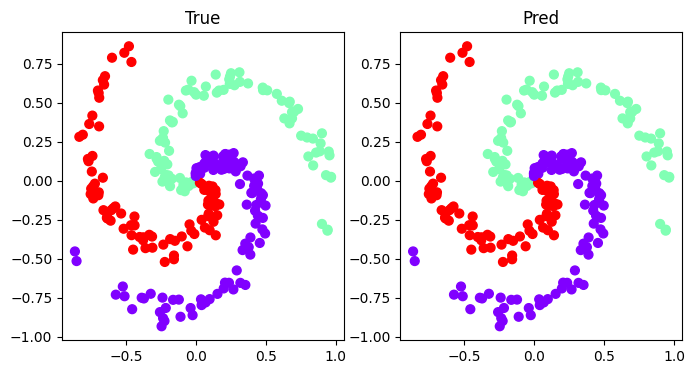

In [81]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=40, cmap=plt.cm.rainbow)
ax2.scatter(X_val[:, 0], X_val[:, 1], c=y_pred, s=40, cmap=plt.cm.rainbow)

ax1.title.set_text('True')
ax2.title.set_text('Pred')
plt.show();

### User params

In [ ]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()

        '''
        Создаем список линейных слоев (полносвязных слоев) с помощью nn.ModuleList.
        У каждого слоя разные размеры входных и выходных данных.
        '''
        self.linear_layers = nn.ModuleList([nn.Linear(D_in, H), nn.Linear(H, D_out)])

        '''
        Создаем параметр смещения my_useless_bias размером 1xH.
        Смещение добавляется к каждому нейрону в слое.
        requires_grad=True указывает, что градиенты этого параметра будут вычисляться.
        '''
        self.my_useless_bias = nn.Parameter(torch.ones(1, H, requires_grad=True))

        '''
        Создаем список параметров смещения more_of_my_useless_biases.
        Каждый элемент списка является параметром смещения размером 1xH.
        requires_grad=True указывает, что градиенты этих параметров будут вычисляться.
        '''
        self.more_of_my_useless_biases = nn.ParameterList([
            nn.Parameter(torch.ones(1, H, requires_grad=True)),
            nn.Parameter(torch.ones(1, H, requires_grad=True)),
            nn.Parameter(torch.ones(1, H, requires_grad=True))
        ])

    def forward(self, X):
        X = F.relu(self.linear_layers[0](X))
        X += self.my_useless_bias
        for b in self.more_of_my_useless_biases:
            X += b
        return F.softmax(self.linear_layers[1](X))

model = MyModule()
list(model.parameters())

## Convolution (свёртка)

На этом семинаре мы посмотрим, как свёртки влияют на изображение и попрактикуемся в вычислении свёрток и пулингов от различных изображений.

Для начала напомним, что такое свёртка:

<img src="https://neurohive.io/wp-content/uploads/2018/07/convolutional-neural-network.gif" width=450 height=400>

*https://neurohive.io/wp-content/uploads/2018/07/convolutional-neural-network.gif*

То есть мы берём фильтр размера FxF, умножаем его на область изображения размером FxF поэлементно, складываем получившиеся поэлемнетные произведения и записываем это число в результирующий тензор.

За исключением архитектур типа MobileNet, третья размерность фильтра всегда свопадает с третьей размерностью входного тензора. Если картинка размера HxWx3, то фильтр будет иметь размер FxFx3, и поэлементное произведение будет производиться по всему объёму.

Напомним два важных параметра операции свертки:

stride -- это размер шага окна свёртка по осям x и y (обычно совпадают, но вполне могут быть и разными).

$padding$ -- это окружение картинки по краям нулями (или чем-то другим) для того, чтобы придать изображению после свёртки нужный размер (пэддинг делается до свёртки).

---

Посмотрим на то, как применение свёртки с определёнными фильтрами влияет на изображение. На этот счёт есть хорошая статья на Хабрахабре:

https://habr.com/post/142818/

Возьмём код из статьи и посмотрим, как будет меняться картинка в зависимости от фильтра:

In [23]:
# !pip install wget

In [36]:
import wget

In [38]:
wget.download('https://www.kotzendes-einhorn.de/blog/wp-content/uploads/2011/01/lenna.jpg')

'lenna.jpg'

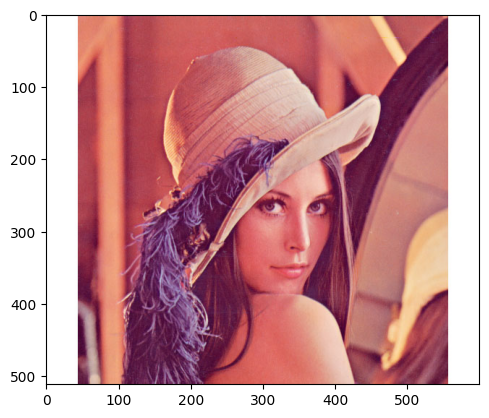

In [39]:
from PIL import Image
from math import ceil, sqrt
from math import floor

import matplotlib.pyplot as plt

#https://habrahabr.ru/post/142818/
def checkByte(a):
    if a > 255:
        a = 255
    if a < 0:
        a = 0
    return a


def conv(a, b):
    sum = 0
    for i in range(len(a)):
        for j in range(len(a[0])):
            sum += a[i][j] * b[i][j]
    return sum


def median(a):
    c = []
    for i in range(len(a)):
        for j in range(len(a[0])):
            c.append(a[i][j])
    c.sort()
    return c[ceil(len(c)/2)]


def max(a):
    c = []
    for i in range(len(a)):
        for j in range(len(a[0])):
            c.append(a[i][j])
    c.sort()
    return c[len(c)-1]


def min(a):
    c = []
    for i in range(len(a)):
        for j in range(len(a[0])):
            c.append(a[i][j])
    c.sort()
    return c[0]

im = Image.open('./lenna.jpg')
pixels = im.load()

plt.imshow(im);

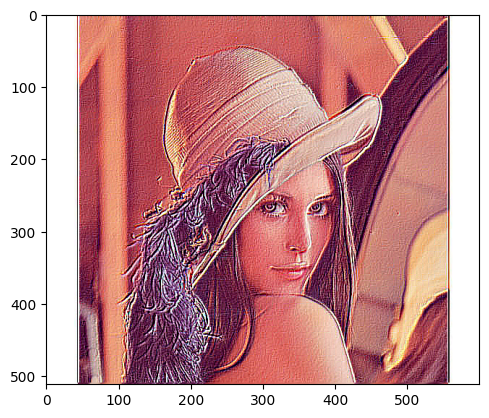

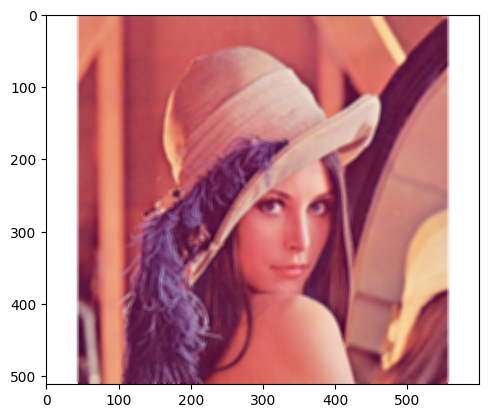

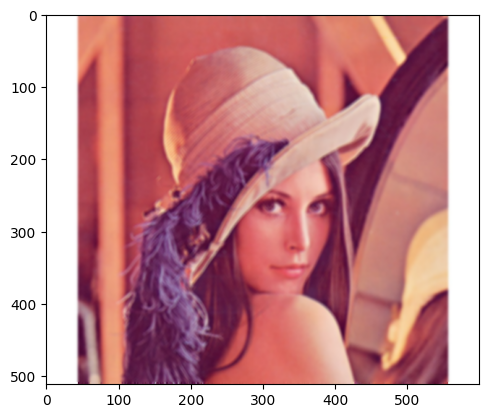

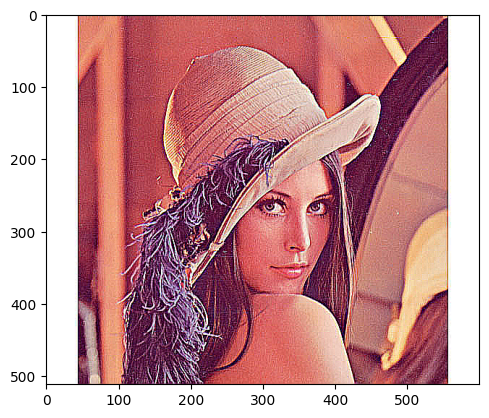

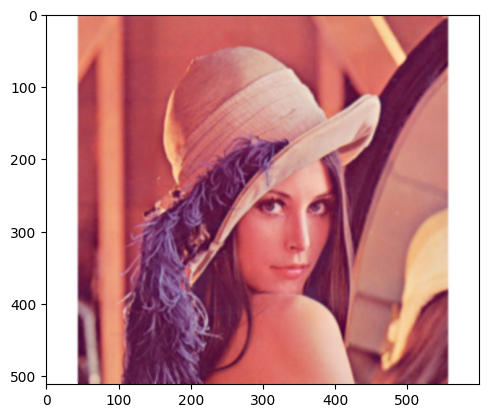

In [89]:
'''
Определяем фильтры для свертки.
'''
filter1 = [
    [-1, -1, 0, 0, 0],
    [0, -1, -1, -1, 0],
    [0, -1, 9, -1, 0],
    [0, -1, -1, -1, 0],
    [0, 0, 0, 0, 0]
]

filter2 = [
    [-1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1],
    [-1, -1, 4, -1, -1],
    [-1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1]
]

filter3 = [
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0]
]

filter4 = [
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]
]

filter5 = [
    [0.5, 1.5, 2, 1.5, 0.5],
    [1.5, 3.5, 5, 3.5, 1.5],
    [  2,   5, 10,  5,   2],
    [1.5, 3.5, 5, 3.5, 1.5],
    [0.5, 1.5, 2, 1.5, 0.5]
]

filters = [filter1, filter2, filter3, filter4, filter5]

for filter in filters:

    '''
    Создаем копию изображения im и загружаем пиксели изображения в переменную pixels2.
    '''
    imFinal = im.copy()
    pixels2 = imFinal.load()

    '''
    Рассчитываем сумму элементов фильтра и сохраняем ее в переменной div.
    Если сумма равна 0, заменяем ее на 1, чтобы избежать деления на 0.
    '''
    div = 0
    for i in range(len(filter)):
        for j in range(len(filter[0])):
            div += filter[i][j]
    if div == 0:
        div = 1

    '''
    Проходим по пикселям изображения, начиная от половины размера фильтра
    и заканчивая шириной - половиной размера фильтра и высотой - половиной размера фильтра.
    '''
    for i in range(floor(len(filter)/2), im.width - floor(len(filter)/2)):
        for j in range(floor(len(filter)/2), im.height - floor(len(filter)/2)):
            '''
            Создаем матрицы для каждого канала (R, G, B) размером фильтра.
            Заполняем их значениями пикселей, соответствующими координатам с учетом смещения фильтра.
            '''
            matrR = []
            matrG = []
            matrB = []

            for n in range(-floor(len(filter)/2), ceil(len(filter)/2)):
                rowR = []
                rowG = []
                rowB = []
                for m in range(-floor(len(filter)/2), ceil(len(filter)/2)):
                    r, g, b = pixels[i + n, j + m]
                    rowR.append(r)
                    rowG.append(g)
                    rowB.append(b)
                matrR.append(rowR)
                matrG.append(rowG)
                matrB.append(rowB)

            '''
            Выполняем операцию свертки для каждого канала (R, G, B),
            делим результат на div для нормализации.
            Применяем функцию checkByte для ограничения значения в диапазоне от 0 до 255.
            '''
            r = checkByte(round(conv(matrR, filter) / div))
            g = checkByte(round(conv(matrG, filter) / div))
            b = checkByte(round(conv(matrB, filter) / div))

           # r = checkByte(min(matrR))
           # g = checkByte(min(matrG))
           # b = checkByte(min(matrB))
            '''
            if r < 512:
                pixels2[i, j] = (255, 255, 255)
            else:
                pixels2[i, j] = (0, 0, 0)
            '''

            '''
            Присваиваем новые значения пикселям изображения.
            '''
            pixels2[i, j] = (r, g, b)

    plt.imshow(imFinal);
    plt.show()

Давайте немного потренируемся в вычислении размера результата применения свёртки к картинке:

### Задача 1

Вычислить размер результата после применения свёртки, $I$ -- размеры входного изображения, $f$ -- размеры фильтра:

1. Пример: $I$ = (50, 50, 3), $f$ = (3, 3), $stride$ = 1. Вычисляем:
* по ширине: 50 - 3 + 1 = 48,
* по высоте: 50 - 3 + 1 = 48,
то есть размер результата будет (48, 48)

2. $I$ = (1024, 768, 3), $f$=(5,5), $stride$ = 2. Вычисляем:


<img src="https://drive.google.com/uc?export=view&id=11bA8ib_n9fRiNyu671VO20YdcMJ_oXX5" width=500/>

Из рисунка видно, что выходная ширина равна количеству нечентых чисел от 1 до 1020, т. е. 510

Аналогично по высоте получаем 382, то есть размер результата будет (510, 382).



3. $I$ = (500, 700, 5), $f$=(7,4), $stride$ = 2

Выведите общую формулу для $I$ = (H, W, C), $f$=(F, F) (фильтры обычно всё же квадратные)

***место, чтобы вписать получивщуюся формулу***

Теперь добавьте в получившуюся формулу $padding = p$:

***место, чтобы вписать формулу с учётом padding'а***

**Вопросы для самоконтроля:**
Что такое свёртка?
Фильтр?
Stride?
Padding?

### Pooling

Pooling (пулинг) -- операция, нужная для уменьшения размерности по ширине и по высоте. Можно брать очень много операций в качестве пулинга, например, минимум из элементов, максимум, среднее, сумму и т.д.

Обычно используется max- и avg-pooling.

Пример применения max-pooling'а:

<img src="https://i.stack.imgur.com/W9a9n.jpg">

*https://i.stack.imgur.com/W9a9n.jpg*

Примеры применения max и avg pooling'ов:


<img src="https://www.researchgate.net/profile/Zenghui_Wang2/publication/317496930/figure/fig1/AS:551445004066816@1508486142257/Average-versus-max-pooling.png">

*https://www.researchgate.net/profile/Zenghui_Wang2/publication/317496930/figure/fig1/AS:551445004066816@1508486142257/Average-versus-max-pooling.png*

Если на вход подаётся изображение с несколькими каналами, то пулинг берётся по каналам, то есть если это цветная картинка HxWxC, и мы применяем к ней pooling 2x2, то получим на выходе (H // 2) x (W // 2) x C

Эта операция весьма простая, но лучше разобрать несколько примеров (см. на доску).

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета:  http://cs231n.github.io/***

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):

http://cs231n.github.io/convolutional-networks/
http://cs231n.github.io/understanding-cnn/
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M